In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from skimage import color
# from tensorflow.keras.applications import ResNet152V2

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow as tf
from keras import Sequential
from keras import layers
from keras import losses
from keras import optimizers

from keras.applications import ResNet152V2
from keras import backend as K

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

DATASET_DIR = 'MMU-Iris-Database'
SEED_NUMBER = 42
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 128

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
# pd.np.random.seed(RANDOM_SEED)
# sklearn.utils.check_random_state(RANDOM_SEED)

# Utils

In [2]:
def plot_image(i, predictions_array, true_label, img, class_names):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

def plot_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.figure(figsize=(20,4))
  plt.subplot(1,2,1)
  plt.plot(epochs, acc, label='Training accuracy')
  plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
  plt.title('Training and validation acc')
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(epochs, loss, label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

# Carrega o dataset

In [3]:
dataset: tf.data.Dataset = tf.keras.utils.image_dataset_from_directory(
  DATASET_DIR,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  seed=SEED_NUMBER,
  batch_size=1)

X = np.concatenate([x for x, y in dataset], axis=0)
X = color.rgb2gray(X)
image_example = X[0]
y = np.concatenate([y for x, y in dataset], axis=0)

Found 225 files belonging to 45 classes.


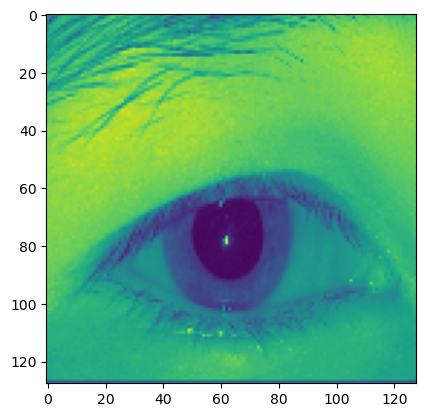

In [4]:
plt.imshow(image_example.astype("uint8"))

# Criação do modelo

In [5]:
def build_model(summary, num_classes):
  K.clear_session()
  
  LEARNING_RATE = 1e-4
  
  model = tf.keras.Sequential([
    layers.Rescaling(1./255),
    
    # Conv1
    layers.Conv2D(32, 5, activation='relu'),
    layers.Conv2D(32, 5, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25, seed=SEED_NUMBER),
    
    # Conv2
    layers.Conv2D(64, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25, seed=SEED_NUMBER),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5)
  ])

  model.compile(
    optimizer=optimizers.Adam(LEARNING_RATE),
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

  if summary:
    model.summary()
  
  return model

In [22]:
def run_training(X_train, y_train, X_test, y_test, model, plot=False, verbose=0):
  callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.005, restore_best_weights=True)
  history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    verbose=verbose,
    callbacks=[callback]
  )
  
  if plot:
    plot_history(history)

In [23]:
model = build_model(False, num_classes)

run_training(X_train, y_train, X_test, y_test, model, True, 1)

Epoch 1/20


/home/krisandre7/mambaforge/envs/iris/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 240, 320, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


ValueError: in user code:

    File "/home/krisandre7/mambaforge/envs/iris/lib/python3.9/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/home/krisandre7/mambaforge/envs/iris/lib/python3.9/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/krisandre7/mambaforge/envs/iris/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/home/krisandre7/mambaforge/envs/iris/lib/python3.9/site-packages/keras/engine/training.py", line 1051, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/krisandre7/mambaforge/envs/iris/lib/python3.9/site-packages/keras/engine/training.py", line 1109, in compute_loss
        return self.compiled_loss(
    File "/home/krisandre7/mambaforge/envs/iris/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/home/krisandre7/mambaforge/envs/iris/lib/python3.9/site-packages/keras/losses.py", line 142, in __call__
        losses = call_fn(y_true, y_pred)
    File "/home/krisandre7/mambaforge/envs/iris/lib/python3.9/site-packages/keras/losses.py", line 268, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/krisandre7/mambaforge/envs/iris/lib/python3.9/site-packages/keras/losses.py", line 1984, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "/home/krisandre7/mambaforge/envs/iris/lib/python3.9/site-packages/keras/backend.py", line 5559, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None,) and (None, 240, 320, 1) are incompatible


In [ ]:
y_pred = model.predict(val_ds).argmax(axis=0)
y_test = np.concatenate([y for x, y in val_ds], axis=0)
np.sort(y_test)

6/6 [==============================] - 0s 14ms/step


array([ 0,  2,  4,  4,  7,  9, 10, 10, 10, 11, 11, 12, 14, 14, 17, 17, 18,
       19, 20, 20, 21, 21, 23, 24, 25, 26, 29, 30, 31, 32, 33, 34, 35, 37,
       37, 37, 38, 39, 40, 41, 42, 42, 43, 44, 44], dtype=int32)

In [ ]:
y_train = np.concatenate([y for x, y in train_ds], axis=0)
np.sort(y_train)

array([ 0,  0,  0,  0,  1,  1,  1,  1,  1,  2,  2,  2,  2,  3,  3,  3,  3,
        3,  4,  4,  4,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  7,  7,  7,
        7,  8,  8,  8,  8,  8,  9,  9,  9,  9, 10, 10, 11, 11, 11, 12, 12,
       12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 15, 15, 15, 15, 15, 16, 16,
       16, 16, 16, 17, 17, 17, 18, 18, 18, 18, 19, 19, 19, 19, 20, 20, 20,
       21, 21, 21, 22, 22, 22, 22, 22, 23, 23, 23, 23, 24, 24, 24, 24, 25,
       25, 25, 25, 26, 26, 26, 26, 27, 27, 27, 27, 27, 28, 28, 28, 28, 28,
       29, 29, 29, 29, 30, 30, 30, 30, 31, 31, 31, 31, 32, 32, 32, 32, 33,
       33, 33, 33, 34, 34, 34, 34, 35, 35, 35, 35, 36, 36, 36, 36, 36, 37,
       37, 38, 38, 38, 38, 39, 39, 39, 39, 40, 40, 40, 40, 41, 41, 41, 41,
       42, 42, 42, 43, 43, 43, 43, 44, 44, 44], dtype=int32)

NameError: name 'predictions' is not defined

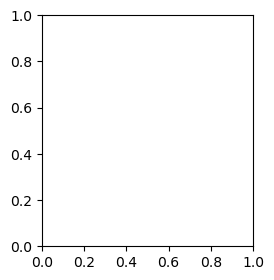

In [ ]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, y_pred[i], test_labels, test_images, class_names)
plt.subplot(1,2,2)
plot_value_array(i, y_pred[i],  test_labels)
plt.show()